In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import socket
import re
import numpy as np

class VirtualMultimeter(object):
    
    current_unit = 'A'
    voltage_unit = 'V'
    resistance_unit = 'Ohm'
    silent = False #Controls the amount of warning printed to screen
    
    def __init__(self,host,port,bufsize=1024,silent=False):
        self.host = host
        self.port = port
        self.bufsize = bufsize
        self.silent = silent
        
        #Try the connection to be valid
        self.open_connection()
        self.close_connection()
        
    def open_connection(self):
        try:
            self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.sock.connect((self.host,self.port))
        except TimeoutError:
            print('Connection Timeout: Are your host and port correct?')
            
        except ConnectionRefuseError:
            print('Connection Refused: Are your host and port correct?')
    
    def close_connection(self):
        try:
            self.sock.shutdown(2)
            self.sock.close()
        except OSError as err:
            if self.silent == False:
                print("OSError error({0}): {1}".format(err.errno, err.strerror))
        
    def communicate(self,message):
        bytemessage = bytes(message,'utf-8')
        
        r=''
        
        self.open_connection()
        #First try to communicate
        self.sock.send(bytemessage)
        r = self.sock.recv(self.bufsize)
        self.close_connection()
        
        #print('1 '+str(r))
        
        counter = 0
        while (counter < 6) and ((str(r)=="b'ERR:BUSY'") or (str(r)=="b''")):
            #print(counter)
            #print(str(r))
            #print(str(r)=="b'ERR:BUSY'")
            #print(str(r)=="b''")
            
            #This should catch the busy and empty string errors.
            self.open_connection()
            self.sock.send(bytemessage)
            r = self.sock.recv(self.bufsize)
            self.close_connection()
            counter += 1
            if self.silent == False:
                print('Connection Busy: Communication Repeated')
        
        if counter == 6:
            if self.silent == False:
                print('WARNING: six connection attempts, all failed. Data may be corrupted')
        
        #self.close_connection()
        
        return r
    
    def parse_answer(self,answer):
        #Using regular expressions strip everything the response that is not a number.
        values = re.findall("[-+]?\d+[\.]?\d*",str(answer))
        if len(values) == 1:
            return float(values[0]) #There is only a single number in the string.
        elif len(values) > 1:
            if self.silent == False:
                print('WARNING: Mutiple values found in return string')
            return np.nan  #There should be only a single number in the string.
        else:
            if self.silent == False:
                print('WARNING: No values found in return string')
            return np.nan #put in a numpy nan which we can handle later easily

    #Writing to the virtual multimeter.    
        
    def write_function(self,mode,value_in):
        answer_set = self.communicate('SET:'+mode+':'+str(value_in))
        #print('2 '+str(answer_set))
        if str(answer_set) == "b'ERR:RNG?'":
            #The requested value is out off range
            answer_get = self.read_function(mode)
            value_out = self.parse_answer(answer_get)
            print('WARNING: The requested value of '+mode+' is outside range.')
            print('The '+mode+' is kept at '+str(value_out))
        else:
            value_out = self.parse_answer(answer_set)
        return value_out
    
    def set_current(self,current):
        self.current = self.write_function('CUR',current)
        return self.current
    
    #Setting the voltage is something that doesn't work
    #Not allowing this 
    #def set_voltage(self,voltage):
    #    self.voltage = self.write_function('VOL',voltage)
    #    return self.voltage
    
    #2015/11/06 Setting the resistance doesn't work anymore
    #def set_resistance(self,resistance):
    #    self.resistance = self.write_function('RES',resistance)
    #    return self.resistance
    
    #Reading out the virtual multimeter
    
    def read_function(self,mode):
        answer = self.communicate('READ:'+mode)
        value = self.parse_answer(answer)
        return value
    
    def read_current(self):
        self.current = self.read_function('CUR')
        return self.current
    
    def read_voltage(self):
        self.voltage = self.read_function('VOL')
        return self.voltage
    
    def read_resistance(self):
        self.resistance = self.read_function('RES')
        return self.resistance

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

class MeasureIV(object):
    averaging = 1
    currents = np.empty((0,0))
    
    def __init__(self,name,Multimeter):
        self.Multimeter = Multimeter
        self.name = name
        
    def set_currents(self,currents):
        self.currents = currents
    
    def set_averaging(self,averaging):
        self.averaging = averaging
    
    def save(self):
        HDF5file = h5py.File(self.name+'.h5', 'w')
        IVgroup = HDF5file.create_group('IVmeasurement')
        MMgroup = IVgroup.create_group('Multimeter')
        HDF5file.close()
        
        print(vars(self))
        print(type(vars(self)))
        
    def measure(self):
        self.voltages = np.zeros((len(self.currents),self.averaging))
        self.currentmeasures = np.zeros((len(self.currents),self.averaging))
        for I in range(len(self.currents)):
            self.Multimeter.set_current(self.currents[I])
            for p in range(self.averaging):
                self.voltages[I,p] = self.Multimeter.read_voltage()
                self.currentmeasures[I,p] = self.Multimeter.read_current()
        
        self.meanvoltages = np.nanmean(self.voltages,axis = 1)
        return self.meanvoltages
    
    def plot(self):
        plt.plot(self.currents,self.meanvoltages,'b.')
        plt.plot(self.currentmeasures,self.meanvoltages,'r.')
        plt.show()

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9  1. ]
1 b'STAT:CUR:1.0A'
2 b'STAT:CUR:1.0A'
1 b'STAT:VOL:11.7015668624V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:11.1206421869V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:10.4959557902V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:8.5821207369V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:11.3471819047V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:8.58218980252V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:9.41657921898V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:9.18139801089V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:8.05289409537V'
1 b'STAT:CUR:1.0A'
1 b'STAT:VOL:10.0382971433V'
1 b'STAT:CUR:1.0A'
1 b'STAT:CUR:0.9A'
2 b'STAT:CUR:0.9A'
1 b'STAT:VOL:7.39334908495V'
1 b'STAT:CUR:0.9A'
1 b'STAT:VOL:9.55540199966V'
1 b'STAT:CUR:0.9A'
1 b'ERR:BUSY'
1 b'STAT:CUR:0.9A'
1 b'STAT:VOL:9.80699197662V'
1 b'STAT:CUR:0.9A'
1 b'STAT:VOL:10.4367030956V'
1 b'STAT:CUR:0.9A'
1 b'STAT:VOL:7.84940792533V'
1 b'STAT:CUR:0.9A'
1 b'ERR:BUSY'
1 b'STAT:CUR:0.9A'
1 b'STAT:VOL:8.75497734437V'
1 

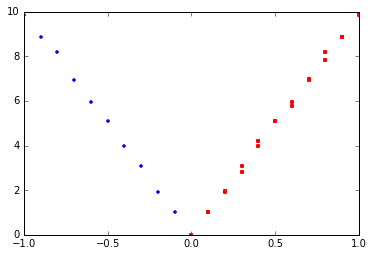

{'currentmeasures': array([[ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ,  1. ],
       [ 0.9,  0.9,  0.9,  0.9,  0.9,  0.9,  0.9,  0.9,  0.9,  0.9],
       [ 0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8],
       [ 0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7,  0.7],
       [ 0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6,  0.6],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4],
       [ 0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1,  0.1],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3,  0.3],
       [ 0.4, 

In [4]:
host="131.180.32.69"
port = 5611
bufsize=1024
VMM = VirtualMultimeter(host,port,bufsize=bufsize,silent=True)

#VMM.set_resistance(3.1415)

MIV = MeasureIV('IVcurve1',VMM)
Currents = np.arange(0,21)/10.0-1.0
Averaging = 10
print(Currents)
MIV.set_currents(Currents)
MIV.set_averaging(Averaging)
MIV.measure()
MIV.plot()
MIV.save()

#print(dir(MIV))
print(vars(MIV))
print(MIV.__dict__)

In [38]:
host="131.180.32.69"
port = 5611
bufsize=1024
VMM = VirtualMultimeter(host,port,bufsize=bufsize,silent=True)

for p in range(0,11):
    print(p/10.0)
    setcurrent = VMM.set_current(p/10.0)
    current = VMM.read_current()
    voltage = VMM.read_voltage()
    resistance = VMM.read_resistance()
    print('Current set to: '+str(setcurrent))
    print('Measurements:')
    print('Voltage :'+str(voltage)+' V')
    print('Resistance :'+str(resistance)+' Ohm')
    print('Current :'+str(current)+' A')

0.0
b'STAT:CUR:0.0A'
Current set to: 0.0
Measurements:
Voltage :0.0 V
Resistance :10.0 Ohm
Current :0.0 A
0.1
b'STAT:CUR:0.1A'
Current set to: 0.1
Measurements:
Voltage :0.935583720931 V
Resistance :10.0 Ohm
Current :0.1 A
0.2
b'STAT:CUR:0.2A'
Current set to: 0.2
Measurements:
Voltage :1.66577349953 V
Resistance :10.0 Ohm
Current :0.2 A
0.3
b'STAT:CUR:0.3A'
Current set to: 0.3
Measurements:
Voltage :3.27495493265 V
Resistance :10.0 Ohm
Current :0.3 A
0.4
b'STAT:CUR:0.4A'
Current set to: 0.4
Measurements:
Voltage :3.48227117499 V
Resistance :10.0 Ohm
Current :0.4 A
0.5
b'STAT:CUR:0.5A'
Current set to: 0.5
Measurements:
Voltage :5.31788451306 V
Resistance :10.0 Ohm
Current :0.5 A
0.6
b'STAT:CUR:0.6A'
Current set to: 0.6
Measurements:
Voltage :7.1240106363 V
Resistance :10.0 Ohm
Current :0.6 A
0.7
b'STAT:CUR:0.7A'
Current set to: 0.7
Measurements:
Voltage :5.73592533554 V
Resistance :10.0 Ohm
Current :0.7 A
0.8
b'STAT:CUR:0.8A'
Current set to: 0.8
Measurements:
Voltage :7.93854761437 V
Re

In [6]:
host="131.180.32.69"
port = 5611
bufsize=1024
VMM = VirtualMultimeter(host,port,bufsize=bufsize,silent=False)
#resistance1 = VMM.read_resistance()
#resistance2 = VMM.set_resistance(2.0)
resistance3 = VMM.read_resistance()
resistance4 = VMM.set_current(1.01)


#print(resistance1)
#print(resistance2)
print(resistance3)
print(resistance4)

1 b'STAT:RES:10Ohm'
1 b'ERR:RNG?'
2 b'ERR:RNG?'
1 b'STAT:CUR:1.0A'
The CUR is kept at 1.0
10.0
1.0
